In [ ]:
without EMA smoothing

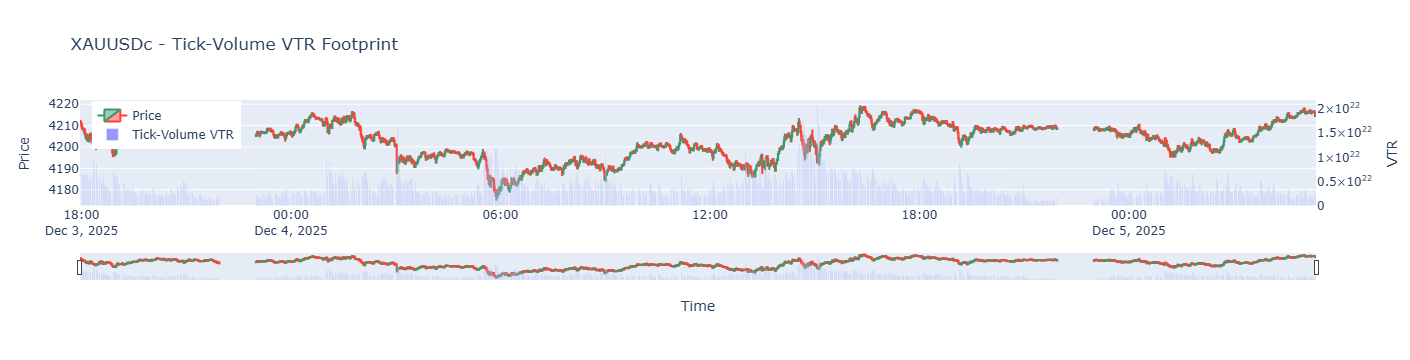

In [9]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------------
# 1. Initialize MT5
# -------------------------------
if not mt5.initialize():
    raise RuntimeError("MT5 initialization failed")

symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M1  # 1-minute bars
bars_to_fetch = 2000  # number of bars

# -------------------------------
# 2. Fetch bars from MT5
# -------------------------------
utc_from = datetime.now()
rates = mt5.copy_rates_from(symbol, timeframe, utc_from, bars_to_fetch)
mt5.shutdown()

if rates is None or len(rates) == 0:
    raise RuntimeError("No bars retrieved from MT5")

df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')

# -------------------------------
# 3. Calculate Tick-Volume VTR
# -------------------------------
# Tick-Volume based VTR: VTR_t = V_t * |V_t - V_{t-1}|
df['VTR'] = df['tick_volume'] * df['tick_volume'].diff().abs()

# Safe fillna for pandas 3.0+
df['VTR'] = df['VTR'].fillna(0)

# -------------------------------
# 4. Plot Footprint-Style Candles
# -------------------------------
colors = ['green' if row['close'] >= row['open'] else 'red' for _, row in df.iterrows()]

fig = go.Figure()

# Candles
fig.add_trace(go.Candlestick(
    x=df['time'],
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='Price'
))

# Overlay raw VTR as bars (footprint)
fig.add_trace(go.Bar(
    x=df['time'],
    y=df['VTR'],
    name='Tick-Volume VTR',
    marker_color='blue',
    opacity=0.4,
    yaxis='y2'
))

# Layout
fig.update_layout(
    title=f"{symbol} - Tick-Volume VTR Footprint",
    xaxis=dict(title='Time'),
    yaxis=dict(title='Price'),
    yaxis2=dict(title='VTR', overlaying='y', side='right', showgrid=False),
    legend=dict(x=0.01, y=0.99)
)

fig.show()


### Fetch bars from a specific date:
1. For example, to start exactly on December 5:
    >`utc_from = datetime(2025, 12, 5)`
3. Or fetch recent bars_to_fetch bars only (no timedelta):
   >This will just get the last 1000 bars from the current time.
    >`rates = mt5.copy_rates_from_pos(symbol, timeframe, 0, bars_to_fetch)`
>`copy_rates_from_pos(symbol, timeframe, 0, bars_to_fetch)` fetches the most recent `bars_to_fetch bars`, ignoring any start date.
4. Or simply
>`utc_from = datetime.now()`

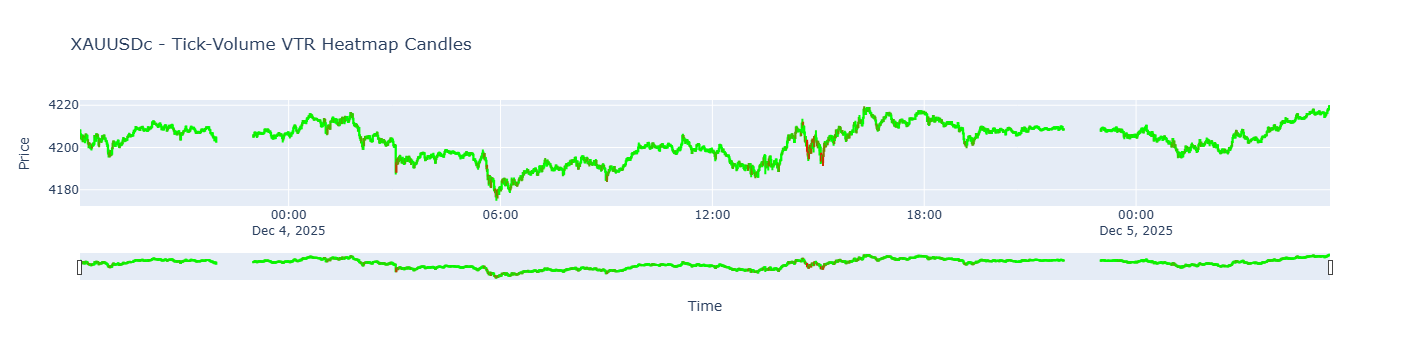

In [10]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------------
# 1. Initialize MT5
# -------------------------------
if not mt5.initialize():
    raise RuntimeError("MT5 initialization failed")

symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M1  # 1-minute bars
bars_to_fetch = 2000  # number of bars

# -------------------------------
# 2. Fetch bars from MT5
# -------------------------------
utc_from = datetime.now()
rates = mt5.copy_rates_from(symbol, timeframe, utc_from, bars_to_fetch)
mt5.shutdown()

if rates is None or len(rates) == 0:
    raise RuntimeError("No bars retrieved from MT5")

df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')

# -------------------------------
# 3. Calculate Tick-Volume VTR
# -------------------------------
df['VTR'] = df['tick_volume'] * df['tick_volume'].diff().abs()
df['VTR'] = df['VTR'].fillna(0)

# -------------------------------
# 4. Normalize VTR for color intensity
# -------------------------------
vtr_max = df['VTR'].max()
vtr_min = df['VTR'].min()
# normalize 0-1
df['VTR_norm'] = (df['VTR'] - vtr_min) / (vtr_max - vtr_min + 1e-9)

# Create a color gradient from light yellow (low) to red (high)
def vtr_to_color(v):
    # v in 0-1
    r = int(255 * v)
    g = int(255 * (1 - v))
    b = 0
    return f'rgb({r},{g},{b})'

df['color'] = df['VTR_norm'].apply(vtr_to_color)

# -------------------------------
# 5. Plot VTR Heatmap Candles
# -------------------------------
fig = go.Figure()

for i, row in df.iterrows():
    fig.add_trace(go.Candlestick(
        x=[row['time']],
        open=[row['open']],
        high=[row['high']],
        low=[row['low']],
        close=[row['close']],
        increasing_line_color=row['color'],
        decreasing_line_color=row['color'],
        showlegend=False
    ))

fig.update_layout(
    title=f"{symbol} - Tick-Volume VTR Heatmap Candles",
    xaxis_title='Time',
    yaxis_title='Price'
)

fig.show()


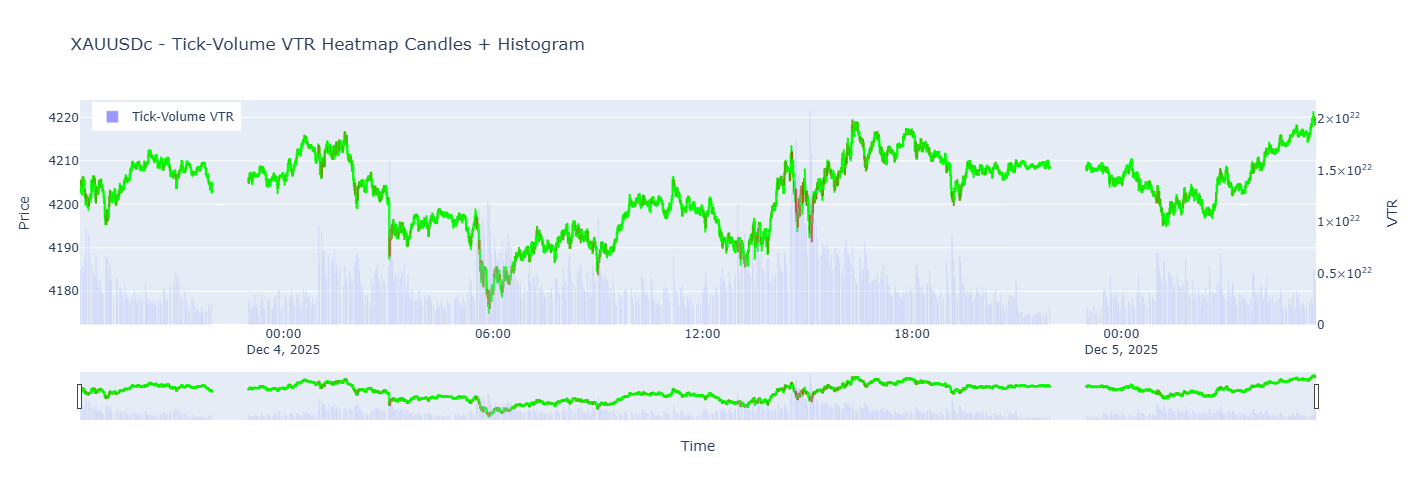

In [11]:
import MetaTrader5 as mt5
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------------
# 1. Initialize MT5
# -------------------------------
if not mt5.initialize():
    raise RuntimeError("MT5 initialization failed")

symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M1  # 1-minute bars
bars_to_fetch = 2000  # number of bars

# -------------------------------
# 2. Fetch bars from MT5
# -------------------------------
utc_from = datetime.now()
rates = mt5.copy_rates_from(symbol, timeframe, utc_from, bars_to_fetch)
mt5.shutdown()

if rates is None or len(rates) == 0:
    raise RuntimeError("No bars retrieved from MT5")

df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')

# -------------------------------
# 3. Calculate Tick-Volume VTR
# -------------------------------
df['VTR'] = df['tick_volume'] * df['tick_volume'].diff().abs()
df['VTR'] = df['VTR'].fillna(0)

# -------------------------------
# 4. Normalize VTR for color intensity
# -------------------------------
vtr_max = df['VTR'].max()
vtr_min = df['VTR'].min()
df['VTR_norm'] = (df['VTR'] - vtr_min) / (vtr_max - vtr_min + 1e-9)

# Color gradient: low VTR = yellow, high VTR = red
def vtr_to_color(v):
    r = int(255 * v)
    g = int(255 * (1 - v))
    b = 0
    return f'rgb({r},{g},{b})'

df['color'] = df['VTR_norm'].apply(vtr_to_color)

# -------------------------------
# 5. Plot Heatmap Candles + VTR Histogram
# -------------------------------
fig = go.Figure()

# Candles with VTR-based gradient
for i, row in df.iterrows():
    fig.add_trace(go.Candlestick(
        x=[row['time']],
        open=[row['open']],
        high=[row['high']],
        low=[row['low']],
        close=[row['close']],
        increasing_line_color=row['color'],
        decreasing_line_color=row['color'],
        showlegend=False
    ))

# Overlay raw VTR as histogram on secondary y-axis
fig.add_trace(go.Bar(
    x=df['time'],
    y=df['VTR'],
    name='Tick-Volume VTR',
    marker_color='blue',
    opacity=0.4,
    yaxis='y2'
))

# Layout with fixed size and dual y-axis
fig.update_layout(
    title=f"{symbol} - Tick-Volume VTR Heatmap Candles + Histogram",
    xaxis_title='Time',
    yaxis=dict(title='Price'),
    yaxis2=dict(title='VTR', overlaying='y', side='right', showgrid=False),
    legend=dict(x=0.01, y=0.99),
    width=1000,
    height=500
)

fig.show()
